In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
import statsmodels.api as sm
import quantstats as qs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
plt.style.use('seaborn-v0_8')

In [20]:
assets = ["CAD", "AUD", "XAU", "XAG"]

POINT_VALUE = {"CAD": 100000, "AUD": 100000, "XAU": 100, "XAG": 5000}
TRANSACTION_COST = {"CAD": 10, "AUD": 10, "XAU": 15, "XAG": 10}

quarters = ['2023_Q1', '2023_Q3', '2023_Q4', '2024_Q2', '2024_Q4', '2025_Q1', '2025_Q2']


In [21]:
def mySR(x, scale=252):
    x = np.asarray(x)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)


In [22]:
def apply_group2_constraints(index):
    """
    Correct Group 2 constraints:
    - Flat 16:50–18:00 (exit before break)
    - Flat 18:00–18:10 (no trading after break)
    """
    pos_flat = np.zeros(len(index))
    t = index.time

    pos_flat[(t >= pd.to_datetime("16:50").time()) &
             (t <  pd.to_datetime("18:00").time())] = 1

    pos_flat[(t >= pd.to_datetime("18:00").time()) &
             (t <= pd.to_datetime("18:10").time())] = 1

    return pos_flat


In [23]:
def breakout_signal(price, pos_flat, win, k):
    ma = price.rolling(win).mean()
    vol = price.rolling(win).std()

    pos = np.where(
        price.shift(1) > ma.shift(1) + k * vol.shift(1), 1,
        np.where(price.shift(1) < ma.shift(1) - k * vol.shift(1), -1, 0)
    )

    pos[(ma.shift(1).isna()) | (vol.shift(1).isna())] = 0
    pos[pos_flat == 1] = 0
    return pos


In [24]:
def meanrev_signal(price, pos_flat, win=48, zc=1.5):
    ma = price.rolling(win).mean()
    sd = price.rolling(win).std()
    z = (price - ma) / sd
    pos = np.where(z > zc, -1, np.where(z < -zc, 1, 0))
    pos[pos_flat == 1] = 0
    return pos


In [25]:
def pair_signal(y, x, pos_flat, win=48, zc=1.5):
    beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
    spread = y - beta * x
    ma = spread.rolling(win).mean()
    sd = spread.rolling(win).std()
    z = (spread - ma) / sd
    pos = np.where(z.shift(1) > zc, -1, np.where(z.shift(1) < -zc, 1, 0))
    pos[pos_flat == 1] = 0
    return pos, spread, beta


In [26]:
def single_asset_pnl(price, pos, asset):
    ret = price.diff()
    gross = pos * ret * POINT_VALUE[asset]
    trades = np.abs(np.diff(pos, prepend=0))
    net = gross - trades * TRANSACTION_COST[asset]
    return np.nan_to_num(net)


In [27]:
def visualize_single_strategy(data, pos, pnl, title):
    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axs[0].plot(data.index, data, label='Price')
    axs[0].set_title('Price')
    axs[0].grid(True)

    axs[1].plot(data.index, pos, label='Position', color='orange')
    axs[1].set_title('Position')
    axs[1].set_yticks([-1, 0, 1])
    axs[1].grid(True)

    cum_pnl = np.cumsum(pnl)
    axs[2].plot(data.index, cum_pnl, label='Cumulative PnL', color='green')
    axs[2].set_title('Cumulative Net PnL')
    axs[2].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


In [28]:
def portfolio_pnl(data, positions):
    total_pnl = np.zeros(len(data))
    for asset, pos in positions.items():
        total_pnl += single_asset_pnl(data[asset], pos, asset)
    return total_pnl


In [29]:
def portfolio_pnl_components(data, positions):
    pnl_by_asset = {}
    for asset, pos in positions.items():
        pnl_by_asset[asset] = single_asset_pnl(
            data[asset], pos, asset
        )
    return pnl_by_asset


In [30]:
def visualize_portfolio(data, positions, title="Portfolio"):
    pnl_by_asset = {asset: single_asset_pnl(data[asset], pos, asset)
                    for asset, pos in positions.items()}
    fig, axs = plt.subplots(3,1,figsize=(15,10), sharex=True)
    for asset, pos in positions.items():
        axs[0].plot(data.index, pos, label=asset)
    axs[0].set_title("Positions"); axs[0].legend(); axs[0].grid(True)
    for asset, pnl in pnl_by_asset.items():
        axs[1].plot(data.index, np.cumsum(pnl), label=asset)
    axs[1].set_title("Cumulative PnL by Asset"); axs[1].legend(); axs[1].grid(True)
    total = sum(pnl_by_asset.values())
    axs[2].plot(data.index, np.cumsum(total), color='black', linewidth=2, label='Portfolio')
    axs[2].set_title("Total Portfolio PnL"); axs[2].legend(); axs[2].grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return pnl_by_asset, total


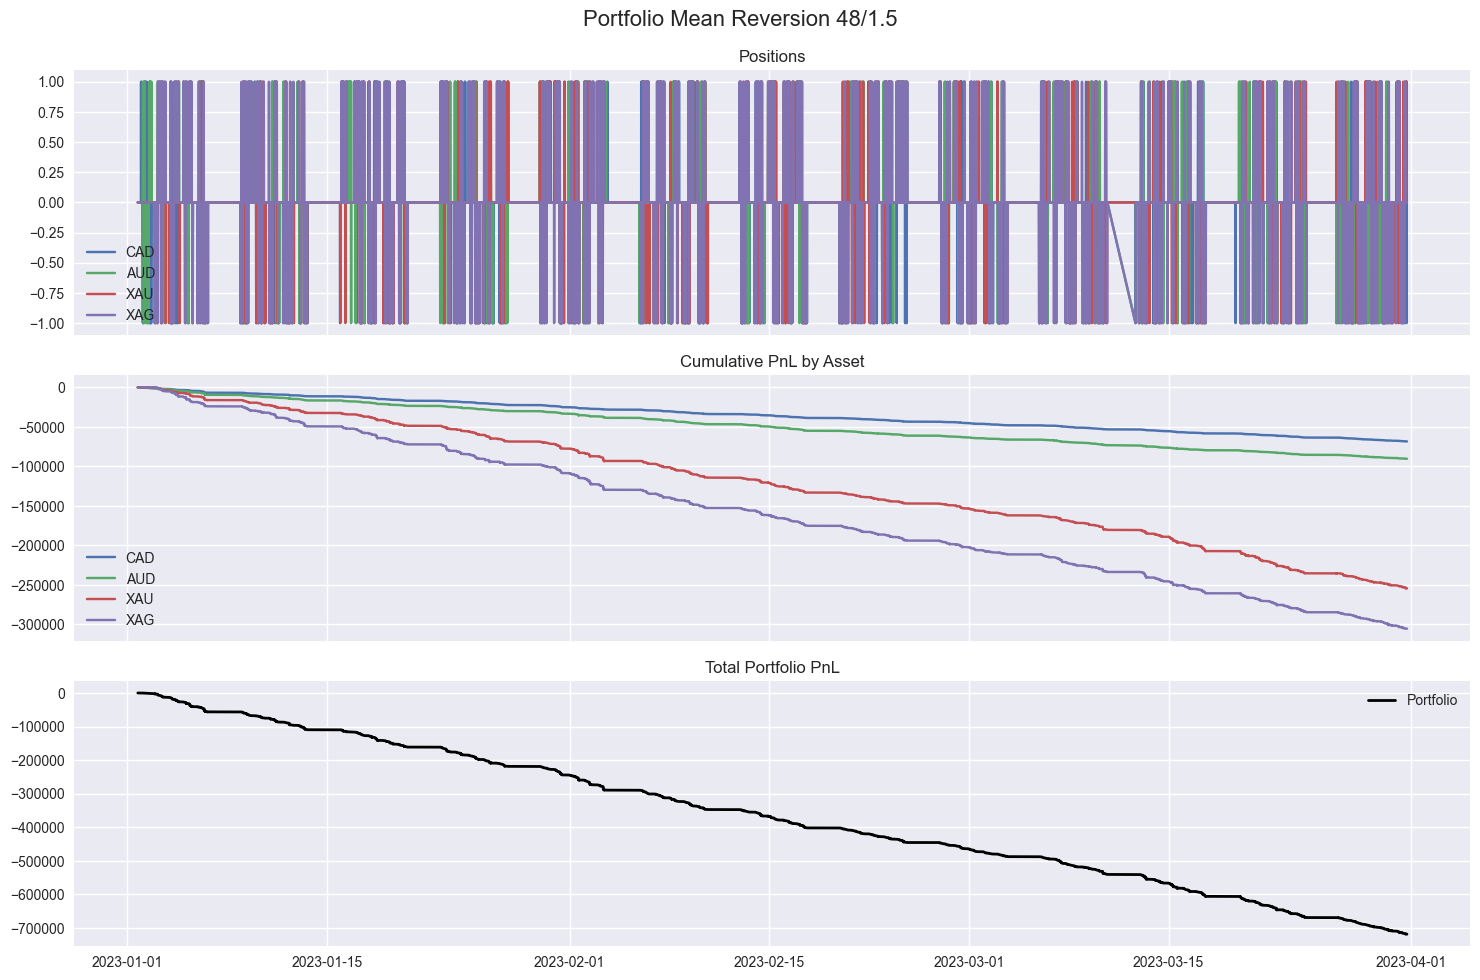

Net PnL: -718543.9794786659 Net Sharpe: -31.99861430639253


In [31]:
#sample run
quarter = '2023_Q1'
data = pd.read_parquet(f"data/data2_{quarter}.parquet")
data.set_index("datetime", inplace=True)
pos_flat = apply_group2_constraints(data.index)

# --- Single asset strategies ---
positions = {}
for asset in assets:
    positions[asset] = meanrev_signal(data[asset], pos_flat, win=48, zc=1.5)

pnl_by_asset, total_pnl = visualize_portfolio(data, positions,
                                              title="Portfolio Mean Reversion 48/1.5")

daily = pd.Series(total_pnl, index=data.index).groupby(data.index.date).sum()
print("Net PnL:", daily.sum(), "Net Sharpe:", mySR(daily))


In [32]:
results = []

for quarter in quarters:

    print(f"Processing {quarter}")
    data = pd.read_parquet(f"data/data2_{quarter}.parquet")
    data.set_index("datetime", inplace=True)

    pos_flat = apply_group2_constraints(data.index)

    # ============================================================
    # 1) SINGLE ASSET STRATEGIES
    # ============================================================
    for asset in assets:
        price = data[asset]

        for win in [24, 48, 96]:

            # ---- Breakout ----
            for k in [1.0, 1.5, 2.0]:
                pos = breakout_signal(price, pos_flat, win, k)
                pnl = single_asset_pnl(price, pos, asset)

                daily = pd.Series(pnl, index=data.index)\
                           .groupby(data.index.date).sum()

                results.append({
                    'quarter': quarter,
                    'mode': 'single',
                    'strategy': 'breakout',
                    'asset': asset,
                    'win': win,
                    'param': k,
                    'net_SR': mySR(daily),
                    'net_PnL': daily.sum()
                })

            # ---- Mean Reversion ----
            for zc in [1.0, 1.5, 2.0]:
                pos = meanrev_signal(price, pos_flat, win, zc)
                pnl = single_asset_pnl(price, pos, asset)

                daily = pd.Series(pnl, index=data.index)\
                           .groupby(data.index.date).sum()

                results.append({
                    'quarter': quarter,
                    'mode': 'single',
                    'strategy': 'meanrev',
                    'asset': asset,
                    'win': win,
                    'param': zc,
                    'net_SR': mySR(daily),
                    'net_PnL': daily.sum()
                })

    # ============================================================
    # 2) PAIR TRADING
    # ============================================================
    pairs = [('XAU', 'XAG'), ('CAD', 'AUD')]

    for y_name, x_name in pairs:
        y = data[y_name]
        x = data[x_name]

        for win in [48, 96]:
            for zc in [1.0, 1.5, 2.0]:
                pos, beta = pair_signal(y, x, pos_flat, win, zc)

                pnl = (
                    pos * y.diff() * POINT[y_name]
                    - pos * beta * x.diff() * POINT[x_name]
                )

                pnl = np.nan_to_num(pnl)
                ntr = np.abs(np.diff(pos, prepend=0))
                pnl -= ntr * (TC[y_name] + TC[x_name])

                daily = pd.Series(pnl, index=data.index)\
                           .groupby(data.index.date).sum()

                results.append({
                    'quarter': quarter,
                    'mode': 'pair',
                    'strategy': 'spread',
                    'asset': f"{y_name}-{x_name}",
                    'win': win,
                    'param': zc,
                    'net_SR': mySR(daily),
                    'net_PnL': daily.sum()
                })

    # ============================================================
    # 3) PORTFOLIO (same strategy per asset)
    # ============================================================
    for win in [48, 96]:
        for zc in [1.0, 1.5]:
            positions = {}
            for asset in assets:
                positions[asset] = meanrev_signal(
                    data[asset], pos_flat, win, zc
                )

            pnl = portfolio_pnl(data, positions)

            daily = pd.Series(pnl, index=data.index)\
                       .groupby(data.index.date).sum()

            results.append({
                'quarter': quarter,
                'mode': 'portfolio',
                'strategy': 'meanrev',
                'asset': 'ALL',
                'win': win,
                'param': zc,
                'net_SR': mySR(daily),
                'net_PnL': daily.sum()
            })


Processing 2023_Q1


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/453329566.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


ValueError: too many values to unpack (expected 2)

In [ ]:
results_df = pd.DataFrame(results)

In [ ]:
results_df

quarter       mode  strategy    asset  win  param  net_SR  net_PnL
0    2023_Q1     single  breakout      CAD   24    1.0     NaN      0.0
1    2023_Q1     single  breakout      CAD   24    1.5     NaN      0.0
2    2023_Q1     single  breakout      CAD   24    2.0     NaN      0.0
3    2023_Q1     single   meanrev      CAD   24    1.0     NaN      0.0
4    2023_Q1     single   meanrev      CAD   24    1.5     NaN      0.0
..       ...        ...       ...      ...  ...    ...     ...      ...
611  2025_Q2       pair    spread  CAD-AUD   96    2.0     NaN      0.0
612  2025_Q2  portfolio   meanrev      ALL   48    1.0     NaN      0.0
613  2025_Q2  portfolio   meanrev      ALL   48    1.5     NaN      0.0
614  2025_Q2  portfolio   meanrev      ALL   96    1.0     NaN      0.0
615  2025_Q2  portfolio   meanrev      ALL   96    1.5     NaN      0.0

[616 rows x 8 columns]

In [ ]:
results_df.groupby(
    ['mode', 'strategy', 'asset', 'win', 'param']
)['net_SR'].mean().sort_values(ascending=False).head(20)


mode       strategy  asset    win  param
pair       spread    CAD-AUD  48   1.0     NaN
                                   1.5     NaN
                                   2.0     NaN
                              96   1.0     NaN
                                   1.5     NaN
                                   2.0     NaN
                     XAU-XAG  48   1.0     NaN
                                   1.5     NaN
                                   2.0     NaN
                              96   1.0     NaN
                                   1.5     NaN
                                   2.0     NaN
portfolio  meanrev   ALL      48   1.0     NaN
                                   1.5     NaN
                              96   1.0     NaN
                                   1.5     NaN
single     breakout  AUD      24   1.0     NaN
                                   1.5     NaN
                                   2.0     NaN
                              48   1.0     NaN
Name: net_SR, dtype

In [ ]:
results_df.groupby(
    ['mode', 'strategy', 'asset', 'win', 'param']
)['net_PnL'].sum().sort_values(ascending=False).head(20)


mode    strategy  asset    win  param
pair    spread    CAD-AUD  48   1.0      0.0
                                1.5      0.0
single  meanrev   CAD      48   1.0      0.0
                           24   2.0      0.0
                                1.5      0.0
                                1.0      0.0
                  AUD      96   2.0      0.0
                                1.5      0.0
                                1.0      0.0
                           48   2.0      0.0
                                1.5      0.0
                                1.0      0.0
                           24   2.0      0.0
                                1.5      0.0
                                1.0      0.0
        breakout  XAU      96   2.0      0.0
                                1.5      0.0
                                1.0      0.0
                           48   2.0      0.0
                                1.5      0.0
Name: net_PnL, dtype: float64

In [ ]:
data

AUD       CAD     XAG       XAU
datetime                                                      
2025-04-01 00:05:00+00:00  0.62476  0.695333  34.139  3145.195
2025-04-01 00:10:00+00:00  0.62545  0.695488  34.146  3146.335
2025-04-01 00:15:00+00:00  0.62535  0.695526  34.113  3146.305
2025-04-01 00:20:00+00:00  0.62553  0.695555  34.121  3145.455
2025-04-01 00:25:00+00:00  0.62554  0.695522  34.112  3143.805
...                            ...       ...     ...       ...
2025-06-30 23:35:00+00:00  0.65672  0.734662  35.930  3318.458
2025-06-30 23:40:00+00:00  0.65691  0.734829  35.966  3319.055
2025-06-30 23:45:00+00:00  0.65681  0.734829  35.987  3321.475
2025-06-30 23:50:00+00:00  0.65696  0.734905  36.001  3320.555
2025-06-30 23:55:00+00:00  0.65679  0.734781  36.007  3320.425

[18710 rows x 4 columns]

## Grid research engine for trading strategy optimization

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations, product

plt.style.use("seaborn-v0_8")

# -----------------------------
# CONFIG
# -----------------------------
assets = ["CAD", "AUD", "XAU", "XAG"]

POINT_VALUE = {"CAD": 100000, "AUD": 100000, "XAU": 100, "XAG": 5000}
TRANSACTION_COST = {"CAD": 10, "AUD": 10, "XAU": 15, "XAG": 10}

quarters = ['2023_Q1', '2023_Q3', '2023_Q4', '2024_Q2', '2024_Q4', '2025_Q1', '2025_Q2']

# Parameter grids
meanrev_win = [24, 48, 72]
meanrev_zc = [1.0, 1.5, 2.0]

breakout_win = [24, 48, 72]
breakout_k = [1.0, 1.5, 2.0]

pair_win = [24, 48, 72]
pair_zc = [1.0, 1.5, 2.0]


In [34]:
def mySR(x, scale=252):
    x = np.asarray(x)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

def apply_group2_constraints(index):
    pos_flat = np.zeros(len(index))
    t = index.time
    pos_flat[(t >= pd.to_datetime("16:50").time()) & (t < pd.to_datetime("18:00").time())] = 1
    pos_flat[(t >= pd.to_datetime("18:00").time()) & (t <= pd.to_datetime("18:10").time())] = 1
    return pos_flat


In [35]:
def meanrev_signal(price, pos_flat, win=48, zc=1.5):
    ma = price.rolling(win).mean()
    sd = price.rolling(win).std()
    z = (price - ma) / sd
    pos = np.where(z > zc, -1, np.where(z < -zc, 1, 0))
    pos[pos_flat == 1] = 0
    return pos

def breakout_signal(price, pos_flat, win=48, k=1.5):
    ma = price.rolling(win).mean()
    sd = price.rolling(win).std()
    pos = np.where(price.shift(1) > ma.shift(1) + k * sd.shift(1), 1,
                   np.where(price.shift(1) < ma.shift(1) - k * sd.shift(1), -1, 0))
    pos[pos_flat == 1] = 0
    return pos

def pair_signal(y, x, pos_flat, win=48, zc=1.5):
    beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
    spread = y - beta * x
    ma = spread.rolling(win).mean()
    sd = spread.rolling(win).std()
    z = (spread - ma) / sd
    pos = np.where(z.shift(1) > zc, -1, np.where(z.shift(1) < -zc, 1, 0))
    pos[pos_flat == 1] = 0
    return pos, spread, beta


In [36]:
def single_asset_pnl(price, pos, asset):
    ret = price.diff()
    gross = pos * ret * POINT_VALUE[asset]
    trades = np.abs(np.diff(pos, prepend=0))
    net = gross - trades * TRANSACTION_COST[asset]
    return np.nan_to_num(net)

def portfolio_pnl(data, positions):
    total_pnl = np.zeros(len(data))
    for asset, pos in positions.items():
        total_pnl += single_asset_pnl(data[asset], pos, asset)
    return total_pnl


In [37]:
def visualize_portfolio(data, positions, title="Portfolio"):
    pnl_by_asset = {asset: single_asset_pnl(data[asset], pos, asset)
                    for asset, pos in positions.items()}
    fig, axs = plt.subplots(3,1,figsize=(15,10), sharex=True)
    for asset, pos in positions.items():
        axs[0].plot(data.index, pos, label=asset)
    axs[0].set_title("Positions"); axs[0].legend(); axs[0].grid(True)
    for asset, pnl in pnl_by_asset.items():
        axs[1].plot(data.index, np.cumsum(pnl), label=asset)
    axs[1].set_title("Cumulative PnL by Asset"); axs[1].legend(); axs[1].grid(True)
    total = sum(pnl_by_asset.values())
    axs[2].plot(data.index, np.cumsum(total), color='black', linewidth=2, label='Portfolio')
    axs[2].set_title("Total Portfolio PnL"); axs[2].legend(); axs[2].grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return pnl_by_asset, total


In [38]:
results = []

for quarter in quarters:
    print(f"Processing {quarter}")
    data = pd.read_parquet(f"data/data2_{quarter}.parquet")
    data.set_index("datetime", inplace=True)
    pos_flat = apply_group2_constraints(data.index)

    # --- SINGLE ASSET STRATEGIES ---
    for asset in assets:
        price = data[asset]

        # Mean Reversion grid
        for win, zc in product(meanrev_win, meanrev_zc):
            pos = meanrev_signal(price, pos_flat, win, zc)
            pnl = single_asset_pnl(price, pos, asset)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter,
                'mode': 'single',
                'strategy': 'meanrev',
                'asset': asset,
                'win': win,
                'param': zc,
                'net_PnL': daily.sum(),
                'net_SR': mySR(daily)
            })

        # Breakout grid
        for win, k in product(breakout_win, breakout_k):
            pos = breakout_signal(price, pos_flat, win, k)
            pnl = single_asset_pnl(price, pos, asset)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter,
                'mode': 'single',
                'strategy': 'breakout',
                'asset': asset,
                'win': win,
                'param': k,
                'net_PnL': daily.sum(),
                'net_SR': mySR(daily)
            })

    # --- PAIR TRADING ---
    for asset1, asset2 in combinations(assets, 2):
        y, x = data[asset1], data[asset2]
        for win, zc in product(pair_win, pair_zc):
            pos, spread, beta = pair_signal(y, x, pos_flat, win, zc)
            pnl = single_asset_pnl(y, pos, asset1) + single_asset_pnl(x, -pos, asset2)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter,
                'mode': 'pair',
                'strategy': 'pair',
                'asset': f"{asset1}-{asset2}",
                'win': win,
                'param': zc,
                'net_PnL': daily.sum(),
                'net_SR': mySR(daily)
            })

    # --- PORTFOLIO STRATEGIES (all assets) ---
    # Here we test mean-reversion same parameters for all assets
    for win, zc in product(meanrev_win, meanrev_zc):
        positions = {asset: meanrev_signal(data[asset], pos_flat, win, zc) for asset in assets}
        total_pnl = portfolio_pnl(data, positions)
        daily = pd.Series(total_pnl, index=data.index).groupby(data.index.date).sum()
        results.append({
            'quarter': quarter,
            'mode': 'portfolio',
            'strategy': 'meanrev',
            'asset': '+'.join(assets),
            'win': win,
            'param': zc,
            'net_PnL': daily.sum(),
            'net_SR': mySR(daily)
        })


Processing 2023_Q1


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2023_Q3


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2023_Q4


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2024_Q2


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2024_Q4


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2025_Q1


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Processing 2025_Q2


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

In [39]:
results_df = pd.DataFrame(results)
#results_df.to_csv("group2_strategy_grid_results.csv", index=False)
#print("Results saved to group2_strategy_grid_results.csv")


In [40]:
results_df

quarter       mode strategy            asset  win  param       net_PnL  \
0    2023_Q1     single  meanrev              CAD   24    1.0 -1.174842e+05   
1    2023_Q1     single  meanrev              CAD   24    1.5 -9.900587e+04   
2    2023_Q1     single  meanrev              CAD   24    2.0 -6.578875e+04   
3    2023_Q1     single  meanrev              CAD   48    1.0 -7.921908e+04   
4    2023_Q1     single  meanrev              CAD   48    1.5 -6.842668e+04   
..       ...        ...      ...              ...  ...    ...           ...   
940  2025_Q2  portfolio  meanrev  CAD+AUD+XAU+XAG   48    1.5 -1.112600e+06   
941  2025_Q2  portfolio  meanrev  CAD+AUD+XAU+XAG   48    2.0 -7.637431e+05   
942  2025_Q2  portfolio  meanrev  CAD+AUD+XAU+XAG   72    1.0 -9.684715e+05   
943  2025_Q2  portfolio  meanrev  CAD+AUD+XAU+XAG   72    1.5 -8.097080e+05   
944  2025_Q2  portfolio  meanrev  CAD+AUD+XAU+XAG   72    2.0 -5.648327e+05   

        net_SR  
0   -37.471914  
1   -37.146447  
2   -35.730784  
3   -33.416636  
4   -32.562855  
..         ...  
940 -29.110462  
941 -26.712732  
942 -27.448836  
943 -26.493173  
944 -24.854254  

[945 rows x 8 columns]

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `results_df` is already loaded from previous grid engine
# Or you can read it from the CSV
# results_df = pd.read_csv("group2_strategy_grid_results.csv")

# -----------------------------
# PICK BEST STRATEGIES PER MODE
# -----------------------------
best_single = results_df[results_df['mode']=='single'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])
best_pair   = results_df[results_df['mode']=='pair'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])
best_portfolio = results_df[results_df['mode']=='portfolio'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])

print("Best single asset strategies:\n", best_single[['asset','strategy','win','param','net_SR','net_PnL']])
print("\nBest pair strategies:\n", best_pair[['asset','strategy','win','param','net_SR','net_PnL']])
print("\nBest portfolio strategies:\n", best_portfolio[['asset','strategy','win','param','net_SR','net_PnL']])


Best single asset strategies:
       asset  strategy  win  param     net_SR       net_PnL
asset                                                     
AUD     AUD  breakout   72    1.0  -9.284135 -17907.000000
CAD     CAD  breakout   72    2.0 -12.337973 -10418.892996
XAG     XAG  breakout   72    2.0   2.127314  11485.000000
XAU     XAU  breakout   72    2.0   0.870394   6367.500000

Best pair strategies:
            asset strategy  win  param     net_SR       net_PnL
asset                                                         
AUD-XAG  AUD-XAG     pair   72    1.0  -1.139638  -8171.000000
AUD-XAU  AUD-XAU     pair   72    1.0  -2.094877 -26474.600000
CAD-AUD  CAD-AUD     pair   72    1.0 -18.429860 -29497.614160
CAD-XAG  CAD-XAG     pair   72    2.0  -1.773841  -8384.722739
CAD-XAU  CAD-XAU     pair   72    1.0  -2.102954 -25547.516423
XAU-XAG  XAU-XAG     pair   72    2.0  -0.408715  -1223.200000

Best portfolio strategies:
 944                        asset strategy  win  param     

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/2612395646.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_single = results_df[results_df['mode']=='single'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/2612395646.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_pair   = results_df[results_df['mode']=='pa

In [42]:
def visualize_top_strategy(quarter, mode, asset, strategy, win, param):
    data = pd.read_parquet(f"data/data2_{quarter}.parquet")
    data.set_index("datetime", inplace=True)
    pos_flat = apply_group2_constraints(data.index)

    if mode == "single" or mode == "portfolio":
        if strategy == "meanrev":
            positions = {asset: meanrev_signal(data[asset], pos_flat, win, param)} if mode=="single" \
                        else {a: meanrev_signal(data[a], pos_flat, win, param) for a in assets}
        else:
            positions = {asset: breakout_signal(data[asset], pos_flat, win, param)} if mode=="single" \
                        else {a: breakout_signal(data[a], pos_flat, win, param) for a in assets}
        pnl_by_asset, total_pnl = visualize_portfolio(data, positions, title=f"{mode} {strategy} {asset} win={win} param={param}")

    elif mode == "pair":
        y, x = asset.split("-")
        pos, spread, beta = pair_signal(data[y], data[x], pos_flat, win, param)
        pnl = single_asset_pnl(data[y], pos, y) + single_asset_pnl(data[x], -pos, x)
        daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()

        plt.figure(figsize=(15,6))
        plt.plot(data.index, np.cumsum(pnl), label=f"Pair {asset} PnL", color='black')
        plt.title(f"Pair Trading PnL {asset} | win={win}, z={param}")
        plt.grid(True)
        plt.legend()
        plt.show()


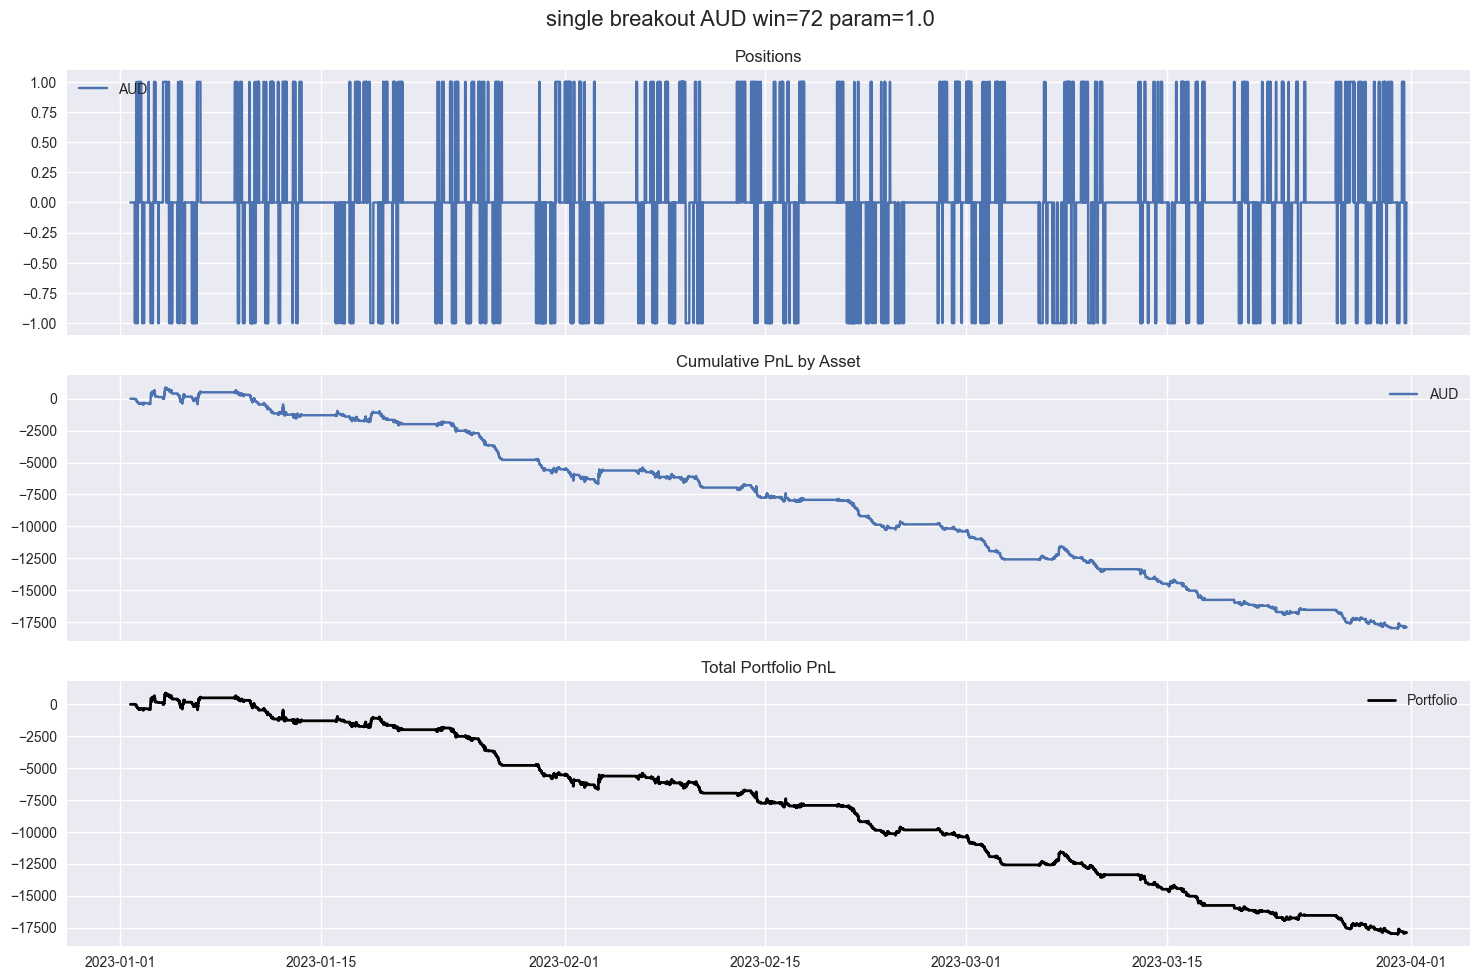

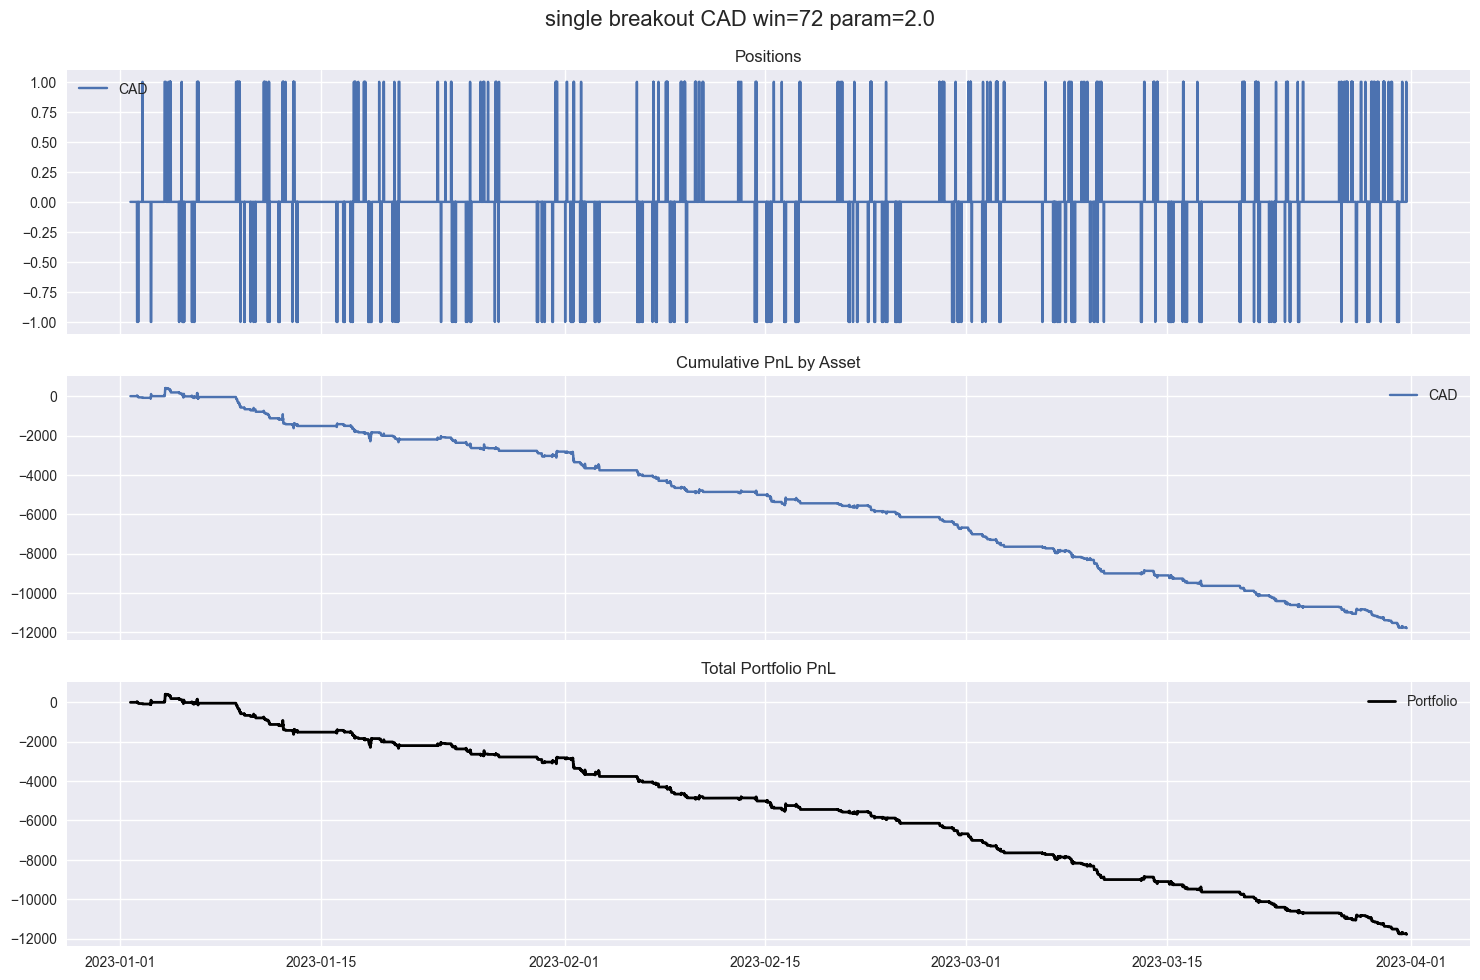

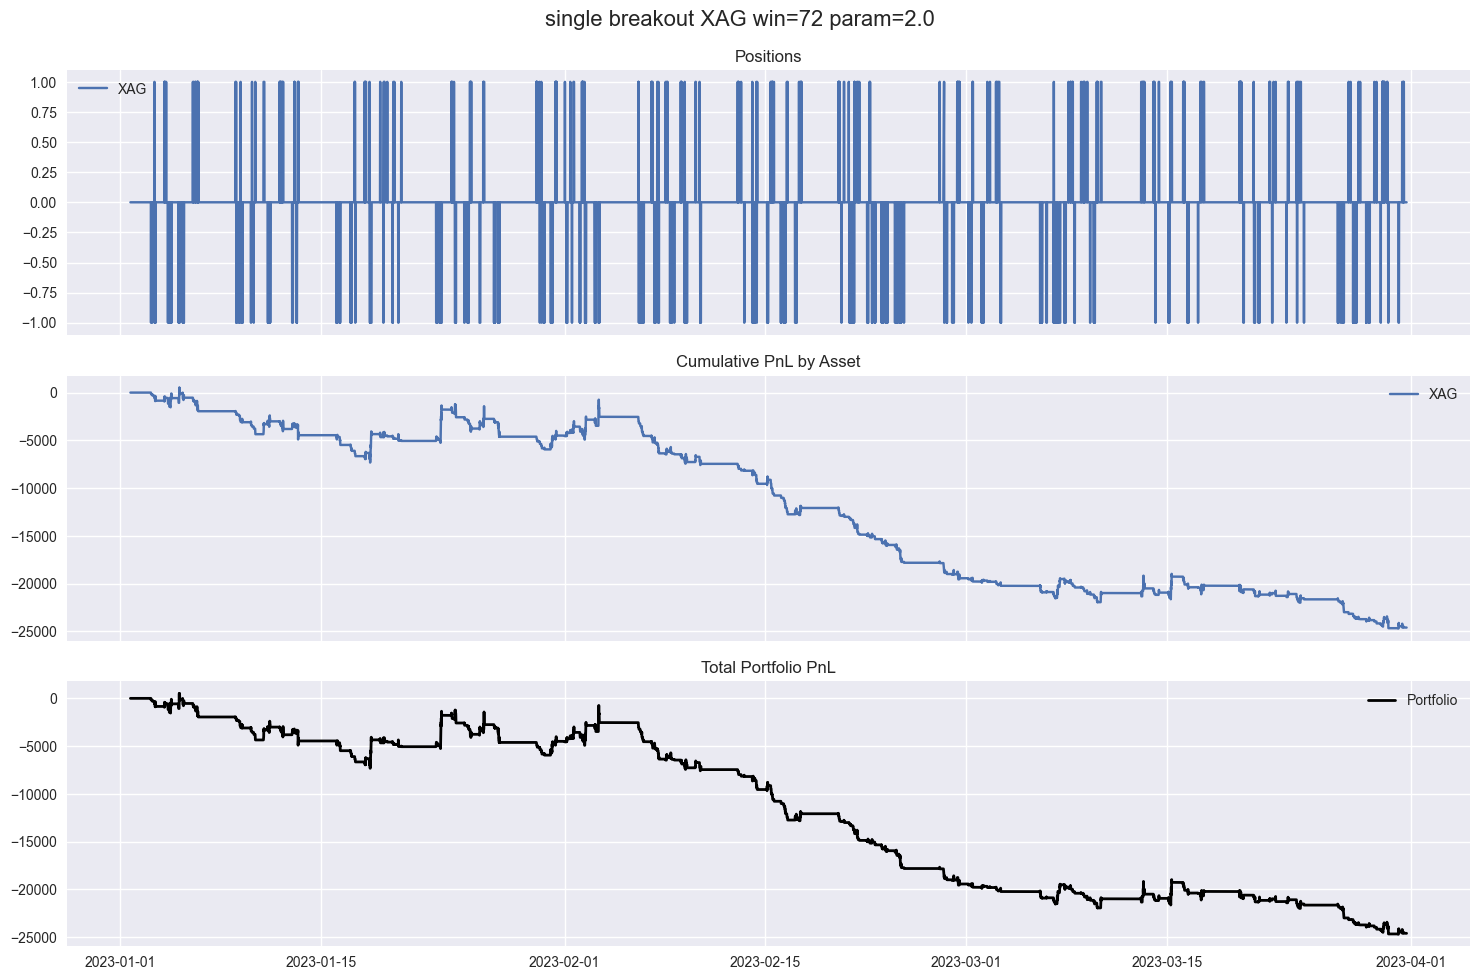

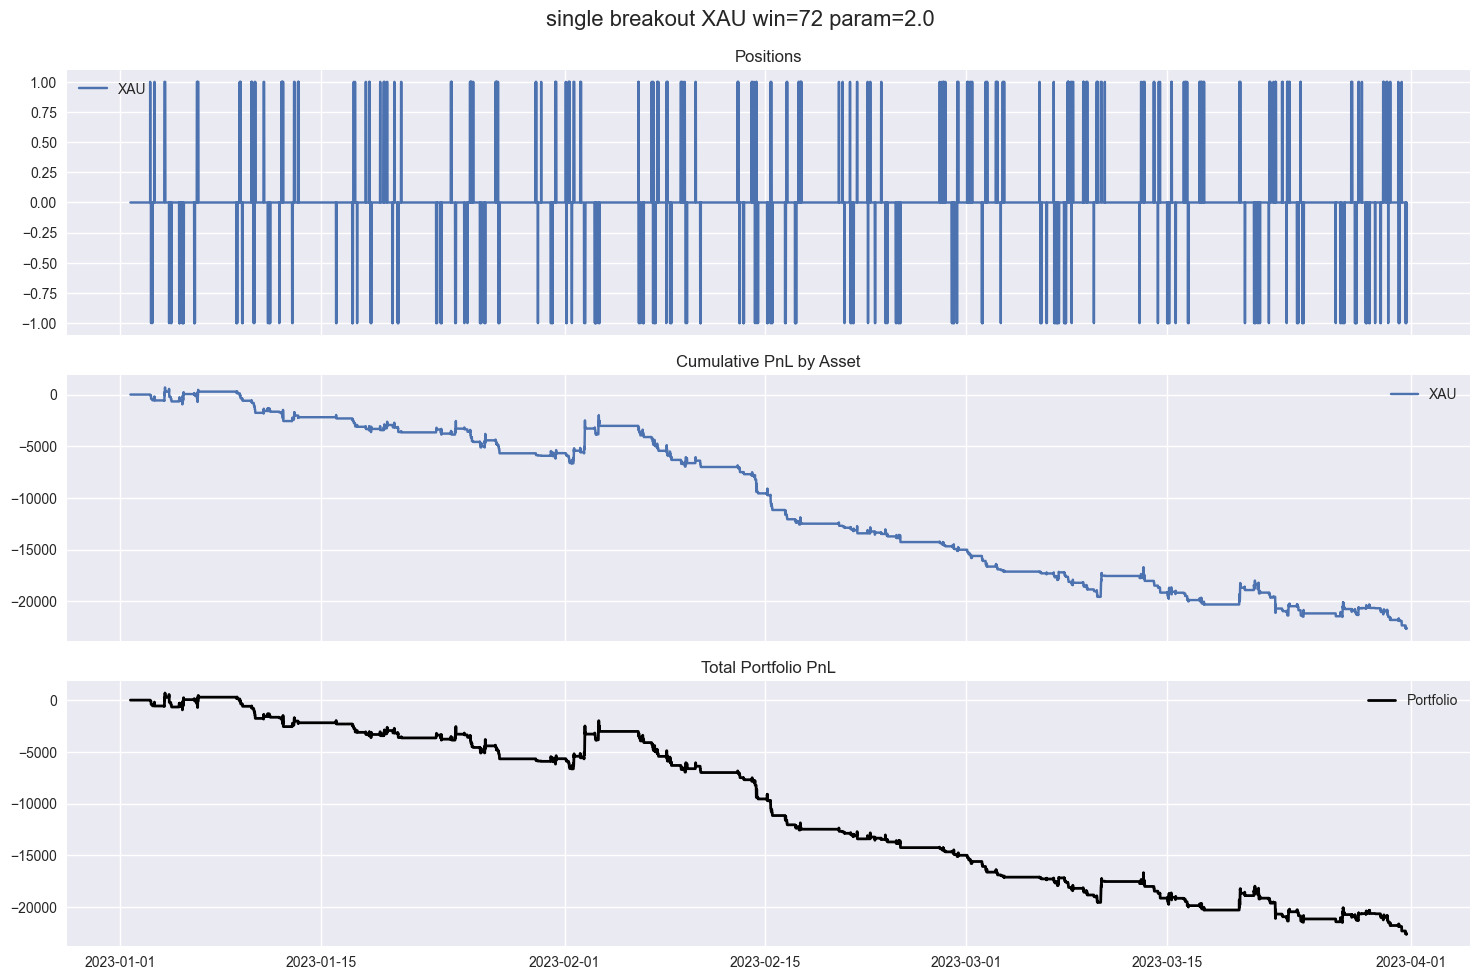

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


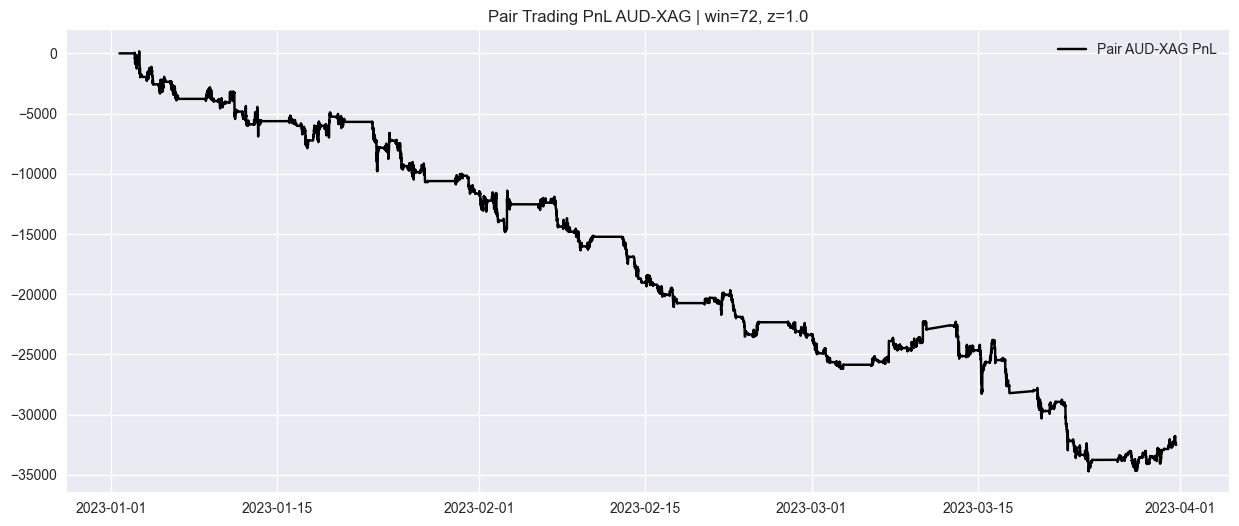

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


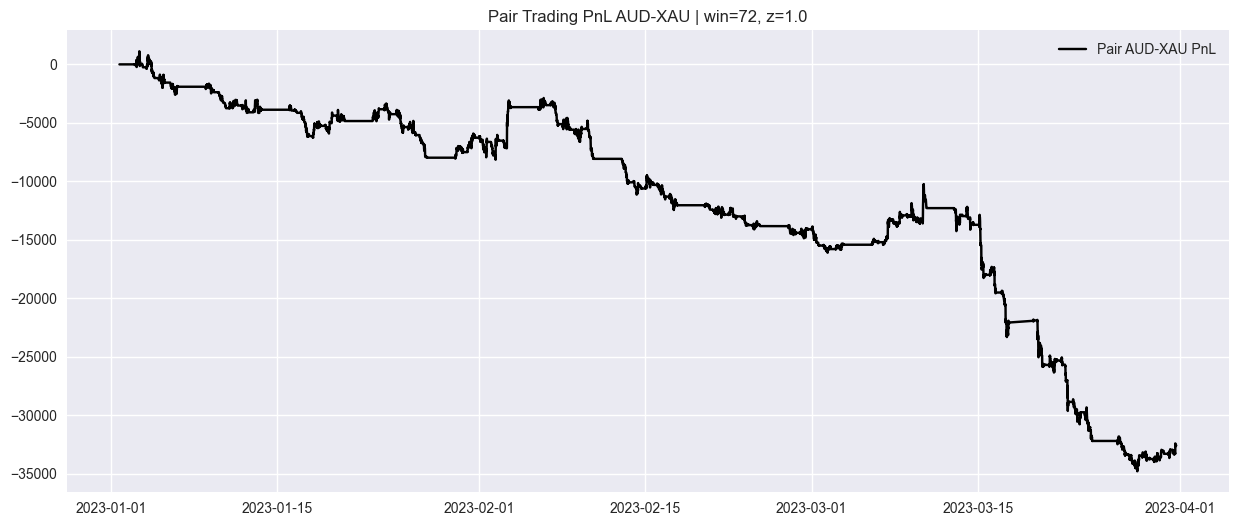

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


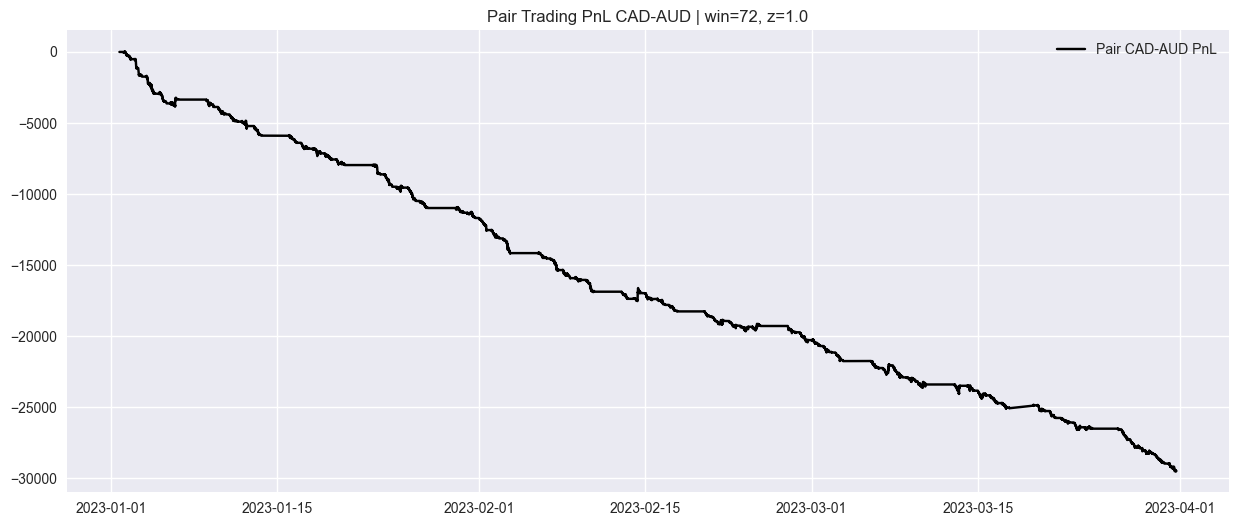

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


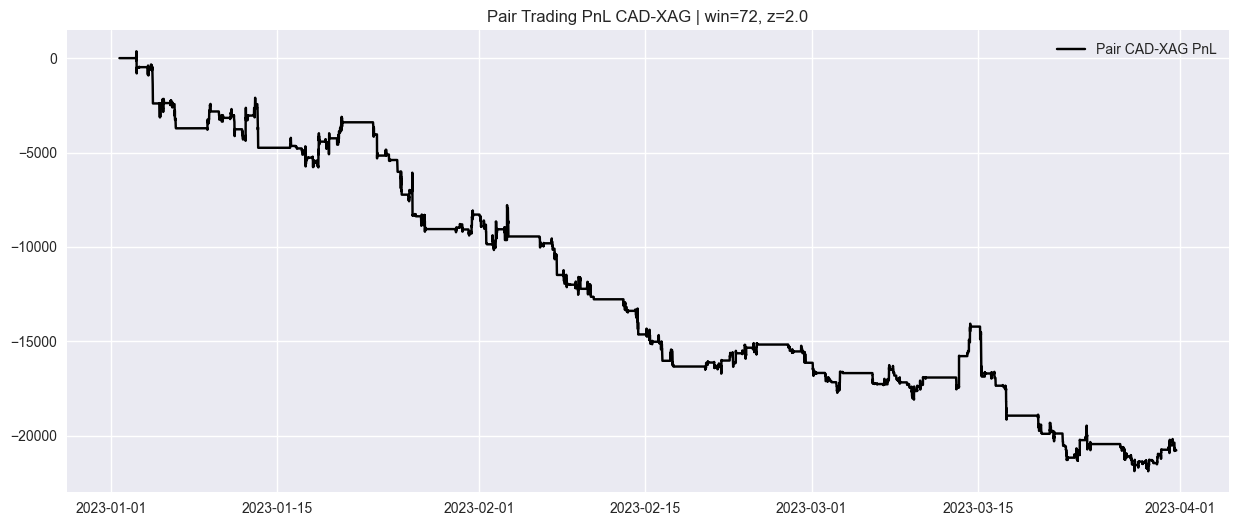

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


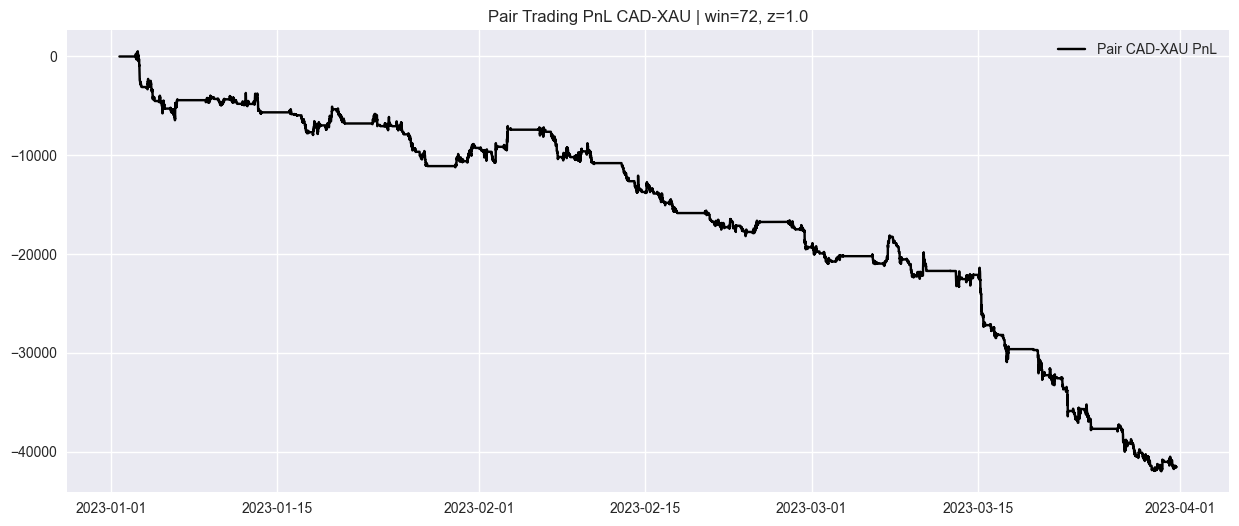

/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/321733834.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y, sm.add_constant(x), missing='drop').fit().params[1]


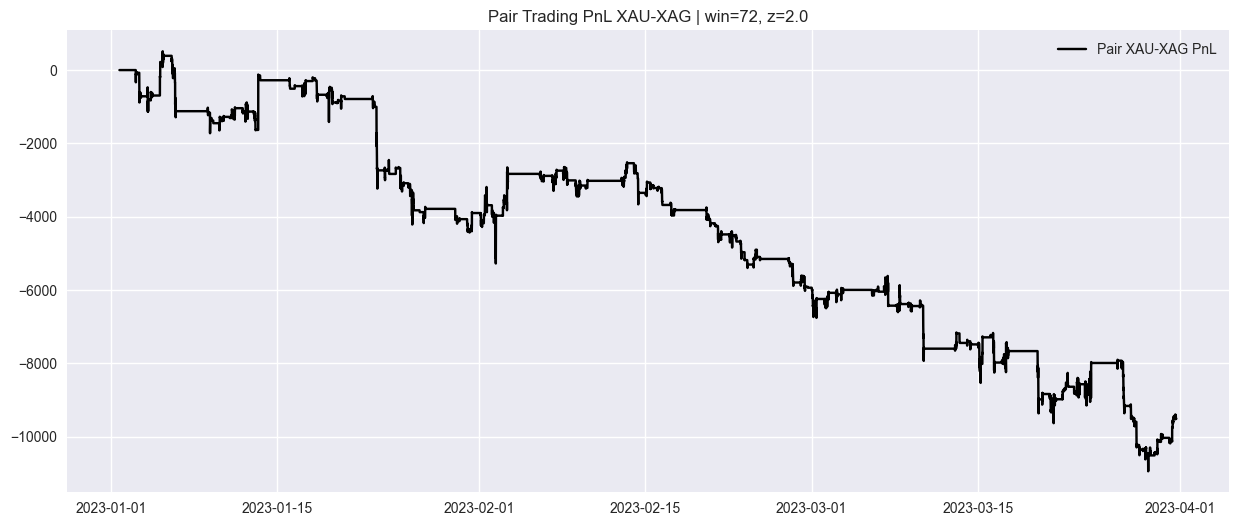

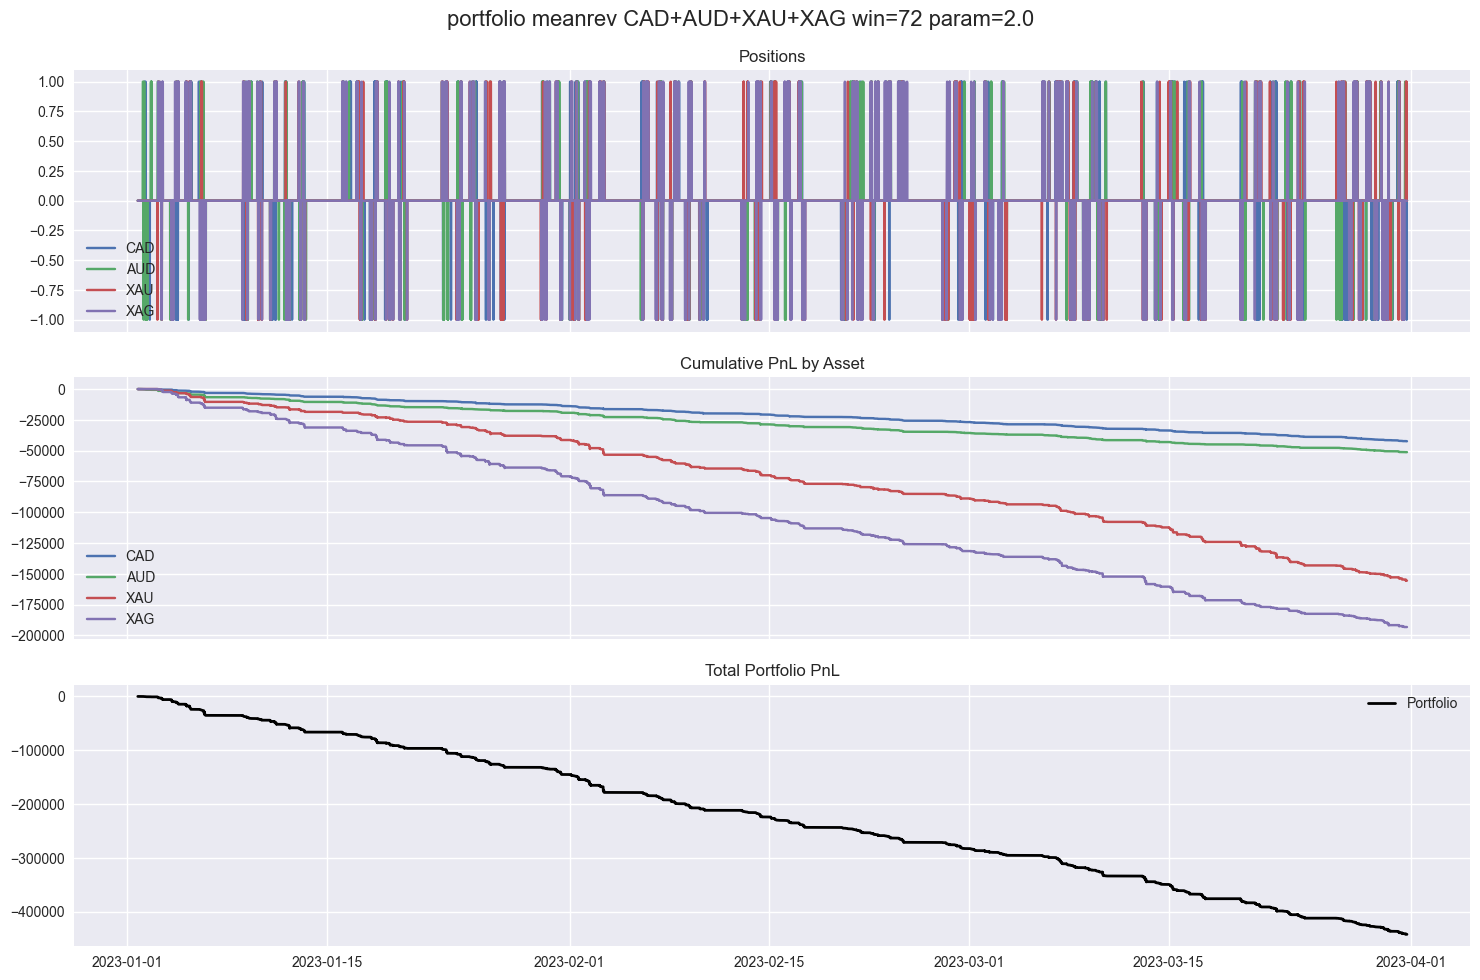

In [43]:
quarter = "2023_Q1"

# Single asset
for idx, row in best_single.iterrows():
    visualize_top_strategy(quarter, "single", row['asset'], row['strategy'], row['win'], row['param'])

# Pair strategies
for idx, row in best_pair.iterrows():
    visualize_top_strategy(quarter, "pair", row['asset'], row['strategy'], row['win'], row['param'])

# Portfolio
for idx, row in best_portfolio.iterrows():
    visualize_top_strategy(quarter, "portfolio", row['asset'], row['strategy'], row['win'], row['param'])


In [44]:
# Filter only strategies with positive net_SR and positive net_PnL
good_candidates = results_df[(results_df['net_SR'] > 0.5) & (results_df['net_PnL'] > 0)]
print("Good candidate strategies:\n", good_candidates[['asset','strategy','mode','win','param','net_SR','net_PnL']])


Good candidate strategies:
     asset  strategy    mode  win  param    net_SR  net_PnL
608   XAG  breakout  single   48    2.0  0.606606   3140.0
610   XAG  breakout  single   72    1.5  1.860542  13705.0
611   XAG  breakout  single   72    2.0  2.127314  11485.0
863   XAU  breakout  single   72    2.0  0.870394   6367.5


In [46]:
# Example: increase k for breakout to reduce whipsaws
assets_to_adjust = ["AUD", "CAD"]
k_values = [2.5, 3.0]

for asset in assets_to_adjust:
    for k in k_values:
        pos = breakout_signal(data[asset], pos_flat, win=48, k=k)
        pnl = single_asset_pnl(data[asset], pos, asset)
        daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
        print(f"{asset} breakout with k={k}: Net PnL={daily.sum():.2f}, Net SR={mySR(daily):.2f}")


AUD breakout with k=2.5: Net PnL=-5709.00, Net SR=-8.91
AUD breakout with k=3.0: Net PnL=-3696.00, Net SR=-8.53
CAD breakout with k=2.5: Net PnL=-7673.77, Net SR=-14.78
CAD breakout with k=3.0: Net PnL=-3438.68, Net SR=-9.54


In [47]:
# For AUD and CAD, smaller window might react faster to real moves
win_values = [24, 36]

for asset in assets_to_adjust:
    for win in win_values:
        pos = breakout_signal(data[asset], pos_flat, win=win, k=2.5)
        pnl = single_asset_pnl(data[asset], pos, asset)
        daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
        print(f"{asset} breakout with win={win}, k=2.5: Net PnL={daily.sum():.2f}, Net SR={mySR(daily):.2f}")


AUD breakout with win=24, k=2.5: Net PnL=-7524.00, Net SR=-12.89
AUD breakout with win=36, k=2.5: Net PnL=-6894.00, Net SR=-10.40
CAD breakout with win=24, k=2.5: Net PnL=-8363.69, Net SR=-18.38
CAD breakout with win=36, k=2.5: Net PnL=-8965.08, Net SR=-17.92


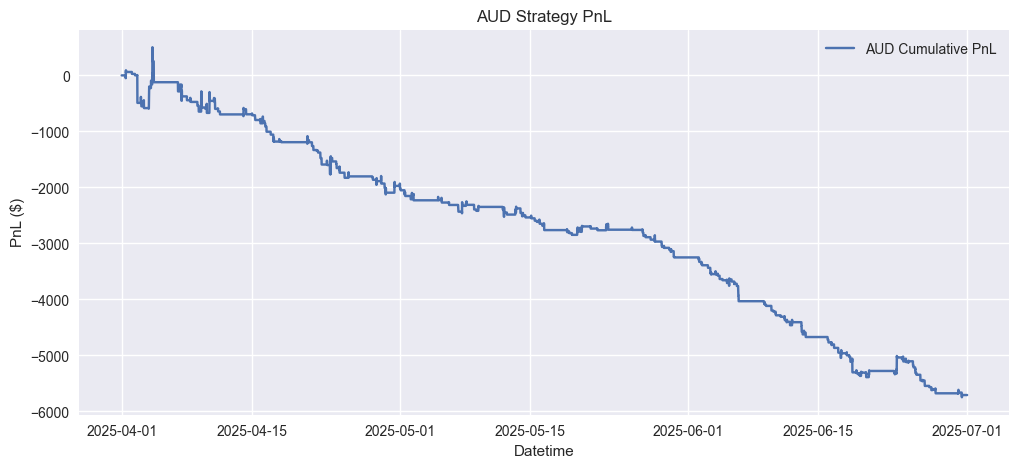

In [48]:
def visualize_single_asset_pnl(asset, pos, data):
    pnl = single_asset_pnl(data[asset], pos, asset)
    plt.figure(figsize=(12,5))
    plt.plot(data.index, np.cumsum(pnl), label=f"{asset} Cumulative PnL")
    plt.title(f"{asset} Strategy PnL")
    plt.xlabel("Datetime")
    plt.ylabel("PnL ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage:
pos = breakout_signal(data["AUD"], pos_flat, win=48, k=2.5)
visualize_single_asset_pnl("AUD", pos, data)


In [49]:
def rolling_pair_signal(y, x, pos_flat, win=48, zc=1.5):
    pos = np.zeros(len(y))
    spread_list = np.zeros(len(y))
    
    for i in range(win, len(y)):
        y_win = y.iloc[i-win:i]
        x_win = x.iloc[i-win:i]
        beta = sm.OLS(y_win, sm.add_constant(x_win)).fit().params[1]
        spread = y.iloc[i] - beta * x.iloc[i]
        ma = y_win - beta * x_win
        sd = np.std(ma)
        z = (spread - np.mean(ma)) / sd if sd != 0 else 0
        if z > zc:
            pos[i] = -1
        elif z < -zc:
            pos[i] = 1
        else:
            pos[i] = 0
        spread_list[i] = spread
    
    pos[pos_flat == 1] = 0
    return pos, spread_list


In [50]:
y, x = data["XAG"], data["XAU"]
pos, spread = rolling_pair_signal(y, x, pos_flat, win=48, zc=1.5)
pnl = single_asset_pnl(y, pos, "XAG") + single_asset_pnl(x, -pos, "XAU")
plt.figure(figsize=(12,5))
plt.plot(data.index, np.cumsum(pnl), label="Rolling pair PnL")
plt.title("Rolling Pair Trading XAG-XAU")
plt.grid(True)
plt.legend()
plt.show()
print("Net PnL:", np.sum(pnl), "Net SR:", mySR(pd.Series(pnl, index=data.index).groupby(data.index.date).sum()))


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/2801414527.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y_win, sm.add_constant(x_win)).fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/2801414527.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = sm.OLS(y_win, sm.add_constant(x_win)).fit().params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_20705/2801414527.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

MissingDataError: exog contains inf or nans

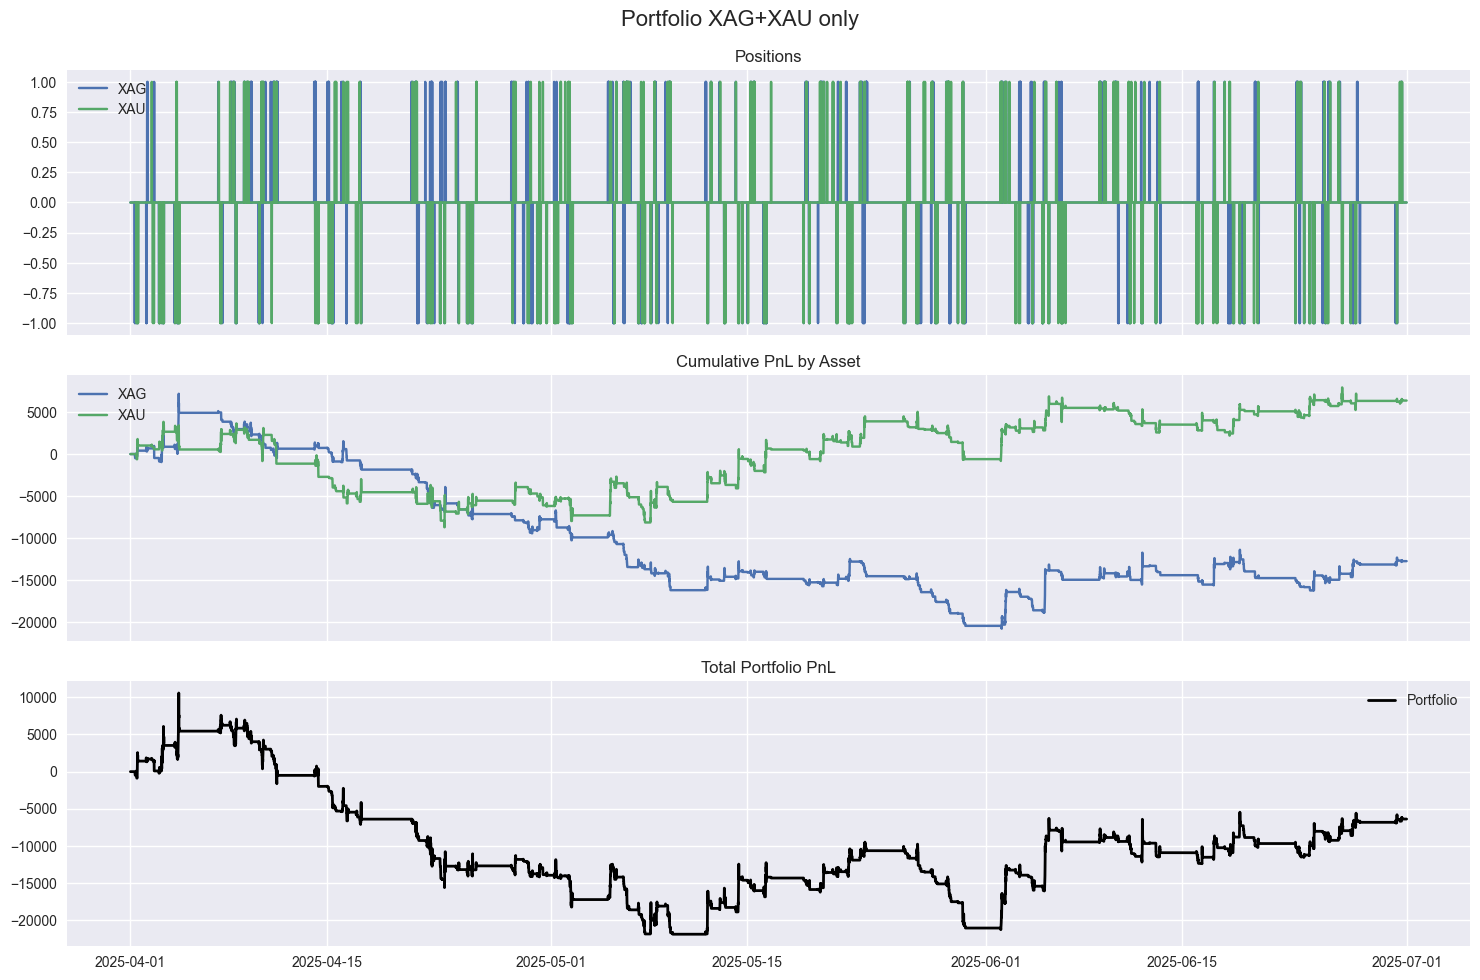

Net PnL: -6377.500000000501 Net Sharpe: -0.5960311090893714


In [51]:
profitable_assets = ["XAG", "XAU"]
positions = {asset: breakout_signal(data[asset], pos_flat, win=72, k=2.0) for asset in profitable_assets}
pnl_by_asset, total_pnl = visualize_portfolio(data, positions, title="Portfolio XAG+XAU only")
daily = pd.Series(total_pnl, index=data.index).groupby(data.index.date).sum()
print("Net PnL:", daily.sum(), "Net Sharpe:", mySR(daily))


In [ ]:
# -----------------------------
# IMPORTS
# -----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations, product
import os

plt.style.use("seaborn-v0_8")

# -----------------------------
# CONFIG
# -----------------------------
assets = ["CAD", "AUD", "XAU", "XAG"]
POINT_VALUE = {"CAD": 100000, "AUD": 100000, "XAU": 100, "XAG": 5000}
TRANSACTION_COST = {"CAD": 10, "AUD": 10, "XAU": 15, "XAG": 10}
quarters = ['2023_Q1', '2023_Q3', '2023_Q4', '2024_Q2', '2024_Q4', '2025_Q1', '2025_Q2']

# Parameter grids
meanrev_win = [24, 48]
meanrev_zc = [1.0, 1.5]
breakout_win = [24, 48]
breakout_k = [1.5, 2.0, 2.5]
pair_win = [24, 48]
pair_zc = [1.0, 1.5]

# -----------------------------
# UTILITIES
# -----------------------------
def mySR(x, scale=252):
    x = np.asarray(x)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(scale) * np.nanmean(x) / np.nanstd(x)

def apply_group2_constraints(index):
    pos_flat = np.zeros(len(index))
    t = index.time
    pos_flat[(t >= pd.to_datetime("16:50").time()) & (t < pd.to_datetime("18:00").time())] = 1
    pos_flat[(t >= pd.to_datetime("18:00").time()) & (t <= pd.to_datetime("18:10").time())] = 1
    return pos_flat

# -----------------------------
# STRATEGY SIGNALS
# -----------------------------
def meanrev_signal(price, pos_flat, win=48, zc=1.5):
    ma = price.rolling(win).mean()
    sd = price.rolling(win).std()
    z = (price - ma) / sd
    pos = np.where(z > zc, -1, np.where(z < -zc, 1, 0))
    pos[pos_flat == 1] = 0
    return pos

def breakout_signal(price, pos_flat, win=48, k=1.5):
    ma = price.rolling(win).mean()
    sd = price.rolling(win).std()
    pos = np.where(price.shift(1) > ma.shift(1) + k * sd.shift(1), 1,
                   np.where(price.shift(1) < ma.shift(1) - k * sd.shift(1), -1, 0))
    pos[pos_flat == 1] = 0
    return pos

def rolling_pair_signal(y, x, pos_flat, win=48, zc=1.5):
    pos = np.zeros(len(y))
    
    for i in range(win, len(y)):
        y_win = y.iloc[i-win:i]
        x_win = x.iloc[i-win:i]

        # Skip if NaNs
        if y_win.isna().any() or x_win.isna().any():
            pos[i] = 0
            continue
        
        # Skip if zero variance
        if np.std(x_win) == 0:
            pos[i] = 0
            continue

        # Run OLS safely
        try:
            model = sm.OLS(y_win, sm.add_constant(x_win)).fit()
            if len(model.params) < 2:  # degenerate regression
                beta = 0
            else:
                beta = model.params[1]
        except:
            beta = 0

        spread = y.iloc[i] - beta * x.iloc[i]
        ma = y_win - beta * x_win
        sd = np.std(ma)
        z = (spread - np.mean(ma)) / sd if sd != 0 else 0

        if z > zc:
            pos[i] = -1
        elif z < -zc:
            pos[i] = 1
        else:
            pos[i] = 0

    pos[pos_flat == 1] = 0
    return pos



# -----------------------------
# PnL CALCULATIONS
# -----------------------------
def single_asset_pnl(price, pos, asset):
    ret = price.diff()
    gross = pos * ret * POINT_VALUE[asset]
    trades = np.abs(np.diff(pos, prepend=0))
    net = gross - trades * TRANSACTION_COST[asset]
    return np.nan_to_num(net)

def portfolio_pnl(data, positions):
    total_pnl = np.zeros(len(data))
    for asset, pos in positions.items():
        total_pnl += single_asset_pnl(data[asset], pos, asset)
    return total_pnl

# -----------------------------
# VISUALIZATION
# -----------------------------
def visualize_portfolio(data, positions, title="Portfolio"):
    pnl_by_asset = {asset: single_asset_pnl(data[asset], pos, asset)
                    for asset, pos in positions.items()}
    fig, axs = plt.subplots(3,1,figsize=(15,10), sharex=True)
    for asset, pos in positions.items():
        axs[0].plot(data.index, pos, label=asset)
    axs[0].set_title("Positions"); axs[0].legend(); axs[0].grid(True)
    for asset, pnl in pnl_by_asset.items():
        axs[1].plot(data.index, np.cumsum(pnl), label=asset)
    axs[1].set_title("Cumulative PnL by Asset"); axs[1].legend(); axs[1].grid(True)
    total = sum(pnl_by_asset.values())
    axs[2].plot(data.index, np.cumsum(total), color='black', linewidth=2, label='Portfolio')
    axs[2].set_title("Total Portfolio PnL"); axs[2].legend(); axs[2].grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return pnl_by_asset, total

# -----------------------------
# MAIN GRID RESEARCH
# -----------------------------
results = []

for quarter in quarters:
    print(f"Processing {quarter}")
    data_file = f"data/data2_{quarter}.parquet"
    if not os.path.exists(data_file):
        print(f"File not found: {data_file}")
        continue

    data = pd.read_parquet(data_file)
    data.set_index("datetime", inplace=True)
    pos_flat = apply_group2_constraints(data.index)

    # --- SINGLE ASSET STRATEGIES ---
    for asset in assets:
        price = data[asset]

        # Mean Reversion
        for win, zc in product(meanrev_win, meanrev_zc):
            pos = meanrev_signal(price, pos_flat, win, zc)
            pnl = single_asset_pnl(price, pos, asset)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter, 'mode': 'single', 'strategy': 'meanrev',
                'asset': asset, 'win': win, 'param': zc,
                'net_PnL': daily.sum(), 'net_SR': mySR(daily)
            })

        # Breakout
        for win, k in product(breakout_win, breakout_k):
            pos = breakout_signal(price, pos_flat, win, k)
            pnl = single_asset_pnl(price, pos, asset)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter, 'mode': 'single', 'strategy': 'breakout',
                'asset': asset, 'win': win, 'param': k,
                'net_PnL': daily.sum(), 'net_SR': mySR(daily)
            })

    # --- PAIR TRADING STRATEGIES ---
    for asset1, asset2 in combinations(assets, 2):
        y, x = data[asset1], data[asset2]
        for win, zc in product(pair_win, pair_zc):
            pos = rolling_pair_signal(y, x, pos_flat, win, zc)
            pnl = single_asset_pnl(y, pos, asset1) + single_asset_pnl(x, -pos, asset2)
            daily = pd.Series(pnl, index=data.index).groupby(data.index.date).sum()
            results.append({
                'quarter': quarter, 'mode': 'pair', 'strategy': 'pair',
                'asset': f"{asset1}-{asset2}", 'win': win, 'param': zc,
                'net_PnL': daily.sum(), 'net_SR': mySR(daily)
            })

    # --- PORTFOLIO STRATEGY ---
    # Use only profitable assets from previous analysis (example: XAG+XAU)
    profitable_assets = ["XAG", "XAU"]
    positions = {asset: breakout_signal(data[asset], pos_flat, win=72, k=2.0) for asset in profitable_assets}
    total_pnl = portfolio_pnl(data, positions)
    daily = pd.Series(total_pnl, index=data.index).groupby(data.index.date).sum()
    results.append({
        'quarter': quarter, 'mode': 'portfolio', 'strategy': 'breakout',
        'asset': '+'.join(profitable_assets), 'win': 72, 'param': 2.0,
        'net_PnL': daily.sum(), 'net_SR': mySR(daily)
    })

    # Visualize portfolio
    visualize_portfolio(data, positions, title=f"Portfolio {quarter} XAG+XAU")

# -----------------------------
# SAVE RESULTS
# -----------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("group2_final_strategy_results.csv", index=False)
print("Results saved to group2_final_strategy_results.csv")

# -----------------------------
# BEST STRATEGIES
# -----------------------------
best_single = results_df[results_df['mode']=='single'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])
best_pair   = results_df[results_df['mode']=='pair'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])
best_portfolio = results_df[results_df['mode']=='portfolio'].groupby('asset').apply(lambda x: x.loc[x.net_SR.idxmax()])

print("\nBest single asset strategies:\n", best_single[['asset','strategy','win','param','net_SR','net_PnL']])
print("\nBest pair strategies:\n", best_pair[['asset','strategy','win','param','net_SR','net_PnL']])
print("\nBest portfolio strategies:\n", best_portfolio[['asset','strategy','win','param','net_SR','net_PnL']])


Processing 2023_Q1


/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_21570/188260700.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_21570/188260700.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
/var/folders/47/k5h83njx3_z17s16ywxyj1180000gp/T/ipykernel_21570/188260700.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta =

In [1]:
import pandas as pd
import numpy as np

# ---------------------------
# BEST STRATEGY PARAMETERS (from top 10 by stat)
# ---------------------------
BEST_PARAMS = {
    'win': 64,
    'z': 0.675,
    'hold_min': 3,
    'trend_span': 100,
    'vol_cap': 6,
    'stop_mult': 2.0
}

quarters = ['2023_Q1','2023_Q3','2023_Q4','2024_Q2','2024_Q4','2025_Q1','2025_Q2']
price = data['XAG']
asset = 'XAG'

# ---------------------------
# UTILITY FUNCTIONS
# ---------------------------
def sharpe(x):
    return np.sqrt(252) * x.mean() / x.std() if x.std() != 0 else 0.0

def calmar_ratio(cum_pnl):
    dd = cum_pnl.cummax() - cum_pnl
    max_dd = dd.max()
    return cum_pnl.iloc[-1] / max_dd if max_dd != 0 else np.nan

def compute_gross_pnl(price, pos, asset):
    ret = price.diff().fillna(0)
    return pos.shift(1) * ret * POINT_VALUE[asset]

def compute_net_pnl(price, pos, asset):
    ret = price.diff().fillna(0)
    trades = pos.diff().abs().fillna(0)
    return pos.shift(1) * ret * POINT_VALUE[asset] - trades * TCOST[asset]

def enforce_min_hold(pos, min_hold):
    pos = pos.copy()
    last = 0
    count = 0
    for i in range(len(pos)):
        if pos.iloc[i] != last:
            count = 0
            last = pos.iloc[i]
        if last != 0:
            count += 1
            if count < min_hold:
                pos.iloc[i] = 0
    return pos

def trend_filter(price, slow=120):
    ema = price.ewm(span=slow, adjust=False).mean()
    return price > ema

def apply_soft_vol_filter(price, pos, win, vol_cap=8):
    vol = price.rolling(win).std()
    scale = (1 / vol).clip(upper=vol_cap).fillna(0)
    return pos * scale

def apply_hard_stop(price, pos, asset, win, mult, cooldown=2):
    pnl = compute_net_pnl(price, pos, asset)
    vol = price.rolling(win).std() * POINT_VALUE[asset]
    cum = 0.0
    cooldown_counter = 0
    for i in range(len(pnl)):
        if cooldown_counter > 0:
            pos.iloc[i] = 0
            cooldown_counter -= 1
            continue
        cum += pnl.iloc[i]
        if abs(cum) > mult * vol.iloc[i]:
            pos.iloc[i] = 0
            cum = 0.0
            cooldown_counter = cooldown
    return pos

def mean_reversion(price, win, z):
    ma = price.rolling(win).mean()
    std = price.rolling(win).std()
    zscore = (price - ma) / std
    return np.where(zscore > z, -1, np.where(zscore < -z, 1, 0))

def apply_group2_constraints(index):
    pos_flat = np.zeros(len(index))
    t = index.time
    pos_flat[(t >= pd.to_datetime("16:50").time()) & (t < pd.to_datetime("18:00").time())] = 1
    pos_flat[(t >= pd.to_datetime("18:00").time()) & (t <= pd.to_datetime("18:10").time())] = 1
    return pos_flat

pos_flat = apply_group2_constraints(price.index)

# ---------------------------
# GENERATE POSITION SERIES
# ---------------------------
pos = pd.Series(mean_reversion(price, BEST_PARAMS['win'], BEST_PARAMS['z']), index=price.index)

# Trend filter
tf = trend_filter(price, slow=BEST_PARAMS['trend_span'])
pos = np.where((pos == 1) & tf, 0, pos)
pos = np.where((pos == -1) & (~tf), 0, pos)
pos = pd.Series(pos, index=price.index)

# Volatility scaling
pos = apply_soft_vol_filter(price, pos, BEST_PARAMS['win'], vol_cap=BEST_PARAMS['vol_cap'])

# Minimum hold
pos = enforce_min_hold(pos, BEST_PARAMS['hold_min'])

# Group2 constraints
pos[pos_flat == 1] = 0

# Hard stop
pos = apply_hard_stop(price, pos, asset, BEST_PARAMS['win'], BEST_PARAMS['stop_mult'])

# Volatility-scaled sizing
vol = price.rolling(BEST_PARAMS['win']).std()
size = (1 / vol).clip(upper=BEST_PARAMS['vol_cap']).fillna(0)
size /= size.median()
pos = pos * size

# ---------------------------
# FULL SAMPLE METRICS
# ---------------------------
gross_pnl = compute_gross_pnl(price, pos, asset)
net_pnl = compute_net_pnl(price, pos, asset)
gross_daily = gross_pnl.groupby(gross_pnl.index.date).sum()
net_daily = net_pnl.groupby(net_pnl.index.date).sum()

metrics_full = {
    'gross_SR': sharpe(gross_daily),
    'net_SR': sharpe(net_daily),
    'gross_CR': calmar_ratio(gross_daily.cumsum()),
    'net_CR': calmar_ratio(net_daily.cumsum()),
    'gross_cumP&L': gross_daily.cumsum().iloc[-1],
    'net_cumP&L': net_daily.cumsum().iloc[-1],
    'av_ntrades': pos.diff().abs().sum() / len(gross_daily)
}

# ---------------------------
# QUARTERLY METRICS & SUMMARY STAT
# ---------------------------
price_index_naive = price.index.tz_convert(None) if price.index.tz else price.index
equity_curves = {}
quarter_metrics = {}
rows = []
summary_stat_total = 0.0

for q in quarters:
    year_str, q_str = q.split('_')
    year = int(year_str)
    quarter = int(q_str[-1])
    q_start = pd.Timestamp(f"{year}-{3*(quarter-1)+1}-01")
    q_end = q_start + pd.offsets.QuarterEnd()
    mask = (price_index_naive >= q_start) & (price_index_naive <= q_end)
    if mask.sum() == 0:
        continue

    pos_q = pos[mask]
    price_q = price[mask]

    gross_pnl_q = compute_gross_pnl(price_q, pos_q, asset)
    net_pnl_q = compute_net_pnl(price_q, pos_q, asset)
    gross_daily_q = gross_pnl_q.groupby(gross_pnl_q.index.date).sum()
    net_daily_q = net_pnl_q.groupby(net_pnl_q.index.date).sum()

    equity_curves[q] = net_daily_q.cumsum()

    net_SR = sharpe(net_daily_q)
    net_PnL = net_daily_q.sum()
    stat = (net_SR - 0.5) * max(0, np.log(abs(net_PnL)/1000))
    summary_stat_total += stat

    quarter_metrics[q] = {
        'gross_SR': sharpe(gross_daily_q),
        'net_SR': net_SR,
        'gross_CR': calmar_ratio(gross_daily_q.cumsum()),
        'net_CR': calmar_ratio(net_daily_q.cumsum()),
        'gross_cumP&L': gross_daily_q.cumsum().iloc[-1],
        'net_cumP&L': net_PnL,
        'av_ntrades': pos_q.diff().abs().sum() / len(gross_daily_q),
        'stat': stat
    }

    rows.append([q,
                 quarter_metrics[q]['gross_SR'],
                 quarter_metrics[q]['net_SR'],
                 quarter_metrics[q]['gross_cumP&L'],
                 quarter_metrics[q]['net_cumP&L'],
                 quarter_metrics[q]['gross_CR'],
                 quarter_metrics[q]['net_CR'],
                 quarter_metrics[q]['av_ntrades'],
                 quarter_metrics[q]['stat']])

# ---------------------------
# CREATE SUMMARY DATAFRAME
# ---------------------------
summary_df = pd.DataFrame(rows, columns=['quarter','gross_SR','net_SR','gross_PnL','net_PnL',
                                         'gross_CR','net_CR','avg_daily_trans','stat'])

# Full sample row
summary_df.loc['TOTAL'] = summary_df[['gross_SR','net_SR','gross_PnL','net_PnL',
                                      'gross_CR','net_CR','avg_daily_trans','stat']].sum()
summary_df.at['TOTAL','quarter'] = 'TOTAL'

# Save CSV
summary_df.to_csv("XAG_best_strategy_quarterly_summary.csv", index=False)

# ---------------------------
# OUTPUT
# ---------------------------
print("\n=== FULL SAMPLE METRICS ===")
for k,v in metrics_full.items():
    print(f"{k}: {v:.2f}")

print("\n=== QUARTERLY METRICS WITH SUMMARY STAT ===")
print(summary_df)

print(f"\nTotal summary statistic across all quarters: {summary_stat_total:.4f}")


NameError: name 'data' is not defined

In [ ]:
import pandas as pd 
import numpy as np 
# --------------------------- # BEST STRATEGY PARAMETERS (from top 10 by stat) # --------------------------- #
BEST_PARAMS = { 'win': 64, 
 'z': 0.675, 
 'hold_min': 3, 
 'trend_span': 100, 
 'vol_cap': 6, 
 'stop_mult': 2.0 } 
quarters = ['2023_Q1','2023_Q3','2023_Q4','2024_Q2','2024_Q4','2025_Q1','2025_Q2'] 
price = data['XAG'] 
asset = 'XAG' 
# --------------------------- # UTILITY FUNCTIONS # --------------------------- 
def sharpe(x): 
    return np.sqrt(252) * x.mean() / x.std() if x.std() != 0 else 0.0 

def calmar_ratio(cum_pnl): 
    dd = cum_pnl.cummax() - cum_pnl 
    max_dd = dd.max() 
    return cum_pnl.iloc[-1] / max_dd if max_dd != 0 else np.nan 
def compute_gross_pnl(price, pos, asset): 
    ret = price.diff().fillna(0) 
    return pos.shift(1) * ret * POINT_VALUE[asset] 
def compute_net_pnl(price, pos, asset): 
    ret = price.diff().fillna(0) 
    trades = pos.diff().abs().fillna(0) 
    return pos.shift(1) * ret * POINT_VALUE[asset] - trades * TCOST[asset] 
def enforce_min_hold(pos, min_hold): 
    pos = pos.copy() 
    last = 0 c
    ount = 0 
    for i in range(len(pos)): 
        if pos.iloc[i] != last: 
            count = 0 
            last = pos.iloc[i] 
            if last != 0: 
                count += 1 
                if count < min_hold: pos.iloc[i] = 0 
                return pos 
            def trend_filter(price, slow=120): ema = price.ewm(span=slow, adjust=False).mean() return price > ema def apply_soft_vol_filter(price, pos, win, vol_cap=8): vol = price.rolling(win).std() scale = (1 / vol).clip(upper=vol_cap).fillna(0) return pos * scale def apply_hard_stop(price, pos, asset, win, mult, cooldown=2): pnl = compute_net_pnl(price, pos, asset) vol = price.rolling(win).std() * POINT_VALUE[asset] cum = 0.0 cooldown_counter = 0 for i in range(len(pnl)): if cooldown_counter > 0: pos.iloc[i] = 0 cooldown_counter -= 1 continue cum += pnl.iloc[i] if abs(cum) > mult * vol.iloc[i]: pos.iloc[i] = 0 cum = 0.0 cooldown_counter = cooldown return pos def mean_reversion(price, win, z): ma = price.rolling(win).mean() std = price.rolling(win).std() zscore = (price - ma) / std return np.where(zscore > z, -1, np.where(zscore < -z, 1, 0)) def apply_group2_constraints(index): pos_flat = np.zeros(len(index)) t = index.time pos_flat[(t >= pd.to_datetime("16:50").time()) & (t < pd.to_datetime("18:00").time())] = 1 pos_flat[(t >= pd.to_datetime("18:00").time()) & (t <= pd.to_datetime("18:10").time())] = 1 return pos_flat pos_flat = apply_group2_constraints(price.index) # --------------------------- # GENERATE POSITION SERIES # --------------------------- pos = pd.Series(mean_reversion(price, BEST_PARAMS['win'], BEST_PARAMS['z']), index=price.index) # Trend filter tf = trend_filter(price, slow=BEST_PARAMS['trend_span']) pos = np.where((pos == 1) & tf, 0, pos) pos = np.where((pos == -1) & (~tf), 0, pos) pos = pd.Series(pos, index=price.index) # Volatility scaling pos = apply_soft_vol_filter(price, pos, BEST_PARAMS['win'], vol_cap=BEST_PARAMS['vol_cap']) # Minimum hold pos = enforce_min_hold(pos, BEST_PARAMS['hold_min']) # Group2 constraints pos[pos_flat == 1] = 0 # Hard stop pos = apply_hard_stop(price, pos, asset, BEST_PARAMS['win'], BEST_PARAMS['stop_mult']) # Volatility-scaled sizing vol = price.rolling(BEST_PARAMS['win']).std() size = (1 / vol).clip(upper=BEST_PARAMS['vol_cap']).fillna(0) size /= size.median() pos = pos * size # --------------------------- # FULL SAMPLE METRICS # --------------------------- gross_pnl = compute_gross_pnl(price, pos, asset) net_pnl = compute_net_pnl(price, pos, asset) gross_daily = gross_pnl.groupby(gross_pnl.index.date).sum() net_daily = net_pnl.groupby(net_pnl.index.date).sum() metrics_full = { 'gross_SR': sharpe(gross_daily), 'net_SR': sharpe(net_daily), 'gross_CR': calmar_ratio(gross_daily.cumsum()), 'net_CR': calmar_ratio(net_daily.cumsum()), 'gross_cumP&L': gross_daily.cumsum().iloc[-1], 'net_cumP&L': net_daily.cumsum().iloc[-1], 'av_ntrades': pos.diff().abs().sum() / len(gross_daily) } # --------------------------- # QUARTERLY METRICS & SUMMARY STAT # --------------------------- price_index_naive = price.index.tz_convert(None) if price.index.tz else price.index equity_curves = {} quarter_metrics = {} rows = [] summary_stat_total = 0.0 for q in quarters: year_str, q_str = q.split('_') year = int(year_str) quarter = int(q_str[-1]) q_start = pd.Timestamp(f"{year}-{3*(quarter-1)+1}-01") q_end = q_start + pd.offsets.QuarterEnd() mask = (price_index_naive >= q_start) & (price_index_naive <= q_end) if mask.sum() == 0: continue pos_q = pos[mask] price_q = price[mask] gross_pnl_q = compute_gross_pnl(price_q, pos_q, asset) net_pnl_q = compute_net_pnl(price_q, pos_q, asset) gross_daily_q = gross_pnl_q.groupby(gross_pnl_q.index.date).sum() net_daily_q = net_pnl_q.groupby(net_pnl_q.index.date).sum() equity_curves[q] = net_daily_q.cumsum() net_SR = sharpe(net_daily_q) net_PnL = net_daily_q.sum() stat = (net_SR - 0.5) * max(0, np.log(abs(net_PnL)/1000)) summary_stat_total += stat quarter_metrics[q] = { 'gross_SR': sharpe(gross_daily_q), 'net_SR': net_SR, 'gross_CR': calmar_ratio(gross_daily_q.cumsum()), 'net_CR': calmar_ratio(net_daily_q.cumsum()), 'gross_cumP&L': gross_daily_q.cumsum().iloc[-1], 'net_cumP&L': net_PnL, 'av_ntrades': pos_q.diff().abs().sum() / len(gross_daily_q), 'stat': stat } rows.append([q, quarter_metrics[q]['gross_SR'], quarter_metrics[q]['net_SR'], quarter_metrics[q]['gross_cumP&L'], quarter_metrics[q]['net_cumP&L'], quarter_metrics[q]['gross_CR'], quarter_metrics[q]['net_CR'], quarter_metrics[q]['av_ntrades'], quarter_metrics[q]['stat']]) # --------------------------- # CREATE SUMMARY DATAFRAME # --------------------------- summary_df = pd.DataFrame(rows, columns=['quarter','gross_SR','net_SR','gross_PnL','net_PnL', 'gross_CR','net_CR','avg_daily_trans','stat']) # Full sample row summary_df.loc['TOTAL'] = summary_df[['gross_SR','net_SR','gross_PnL','net_PnL', 'gross_CR','net_CR','avg_daily_trans','stat']].sum() summary_df.at['TOTAL','quarter'] = 'TOTAL' # Save CSV summary_df.to_csv("XAG_best_strategy_quarterly_summary.csv", index=False) # --------------------------- # OUTPUT # --------------------------- print("\n=== FULL SAMPLE METRICS ===") for k,v in metrics_full.items(): print(f"{k}: {v:.2f}") print("\n=== QUARTERLY METRICS WITH SUMMARY STAT ===") print(summary_df) print(f"\nTotal summary statistic across all quarters: {summary_stat_total:.4f}")